## **Libraries import for EDA**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn import decomposition
from scipy.stats import pearsonr
from crm_rfm_modeling.rfm import RFM
%matplotlib inline

### **Function to evaluate the data available in a DataFrame**

In [2]:
def columnsDataAvailable(df, perc):
    ''' Creating a Function to evaluate the percentage of data available for each columns and filtering by a chosen % (data deleted under it) which data are kept.
    A bar graph with data kept and their % available would be shown. Data should be a DataFrame and Perc a floating number. It returns a DataFrame filtered.
    Keep in mind that a row is add in the dataSet! The function can only take columns type str!!! It also evaluates the first and last columns with data'''
    valueslast = df.apply(pd.Series.last_valid_index, axis=1)
    valuesfirst = df.apply(pd.Series.first_valid_index, axis=1)

    list_first = [df.columns.get_loc(f) for f in valuesfirst]
    list_last = [df.columns.get_loc(l)for l in valueslast]

    firstcolumns_loc = min(list_first)
    lastcolumns_loc = max(list_last)

    print('columns with first values is {} and columns with last value is {}'.format(
        df.columns[firstcolumns_loc], df.columns[lastcolumns_loc]))

    dataSum = 0
    newData = df.iloc[:, firstcolumns_loc:(lastcolumns_loc+1)]
    percASeries = pd.Series(name='AvailableData %', dtype=float)

    for i in newData.columns:
        dataSum += newData[i].notna().sum()
        percAvailable = (((newData[i].notna().sum())/newData.shape[0])*100)
        if percAvailable < perc:
            newData = newData.drop(i, axis=1)
        else:
            percASeries[i] = percAvailable

        dataSumPerc = (dataSum/(newData.shape[0]*newData.shape[1]))*100

    print('There is {} percent of values available in the Dataframe, available data above {} percent have been kept'.format(dataSumPerc, perc))

    # Bar Graph with the kept data and their percentage
    if int(newData.shape[1]/2) > 20:
        figure1 = plt.figure(figsize=(18, 6))
    else:
        figure1 = plt.figure(figsize=(int(newData.shape[1]/2), 6))

    ax = percASeries.plot(kind='bar', ylabel='Pourcentage %')
    plt.title('Données disponibles')
    # Loop to show labels above the bars
    for x, y in zip(range(0, len(percASeries.index)), percASeries.values):
        ax.text(x, y+1, '%.1f' % (y), ha='center', va='bottom', size=7)
    plt.savefig('Données disponibles.png', dpi=300, bbox_inches='tight')
    plt.show()

    return newData

## **Importing and taking basics informations on the different files**

In [3]:
pd.set_option('display.max_columns', None)
data_customers = pd.read_csv('olist_customers_dataset.csv')
data_customers.name = 'customers'
data_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [4]:
data_geo = pd.read_csv('olist_geolocation_dataset.csv')
data_geo.name = 'geo'
data_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [5]:
data_order_items = pd.read_csv('olist_order_items_dataset.csv')
data_order_items.name = 'order_items'
data_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [6]:
data_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
data_order_payments.name = 'order_payments'
data_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [7]:
data_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
data_order_reviews.name = 'order_reviews'
data_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [8]:
data_orders = pd.read_csv('olist_orders_dataset.csv')
data_orders.name = 'orders'
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [9]:
data_products = pd.read_csv('olist_products_dataset.csv')
data_products.name = 'products'
data_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [10]:
data_sellers = pd.read_csv('olist_sellers_dataset.csv')
data_sellers.name = 'sellers'
data_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [11]:
data_categ = pd.read_csv('product_category_name_translation.csv')
data_categ.name = 'categ'
data_categ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


--> we have 9 files available and there are linkable via specific keys

### **Function to evaluate unique object data in our files**

In [12]:
def uniques_values(df):
    '''Function to calculate and display the unique values present in columns of a DataFrame
    Carreful, it takes into accounts only object datas '''

    print(f'File {df.name}')
    print(f'data rows: {df.shape[0]}')

    for col in df.columns:
        if df[col].dtype == 'object':
            print(f'{col} as : {df[col].nunique()} unique values')
    print('_ '*20)

In [13]:
uniques_values(data_customers)
uniques_values(data_orders)
uniques_values(data_order_items)
uniques_values(data_order_payments)
uniques_values(data_order_reviews)
uniques_values(data_products)
uniques_values(data_sellers)
uniques_values(data_categ)

File customers
data rows: 99441
customer_id as : 99441 unique values
customer_unique_id as : 96096 unique values
customer_city as : 4119 unique values
customer_state as : 27 unique values
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
File orders
data rows: 99441
order_id as : 99441 unique values
customer_id as : 99441 unique values
order_status as : 8 unique values
order_purchase_timestamp as : 98875 unique values
order_approved_at as : 90733 unique values
order_delivered_carrier_date as : 81018 unique values
order_delivered_customer_date as : 95664 unique values
order_estimated_delivery_date as : 459 unique values
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
File order_items
data rows: 112650
order_id as : 98666 unique values
product_id as : 32951 unique values
seller_id as : 3095 unique values
shipping_limit_date as : 93318 unique values
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
File order_payments
data rows: 103886
order_id as : 99440 unique values
payment_type as : 5 unique values
_ _ _ _ _ 

## **Start the exploration with the file customers (basic market informations)**

### **Let's try to identify if there is any duplicate data and how many unique client there is**

In [14]:
data_customers['customer_id'].duplicated().sum()

0

--> there is no duplicated data concerning the client order

In [15]:
data_customers['customer_unique_id'].duplicated().sum()

3345

--> it seems that we probably have clients that have make several orders, let's try to identify them

In [16]:
data_customers['customer_unique_id'].nunique()

96096

--> we have 96096 unique client in the dataframe customers

### **Customer repartion in fonction of the state**

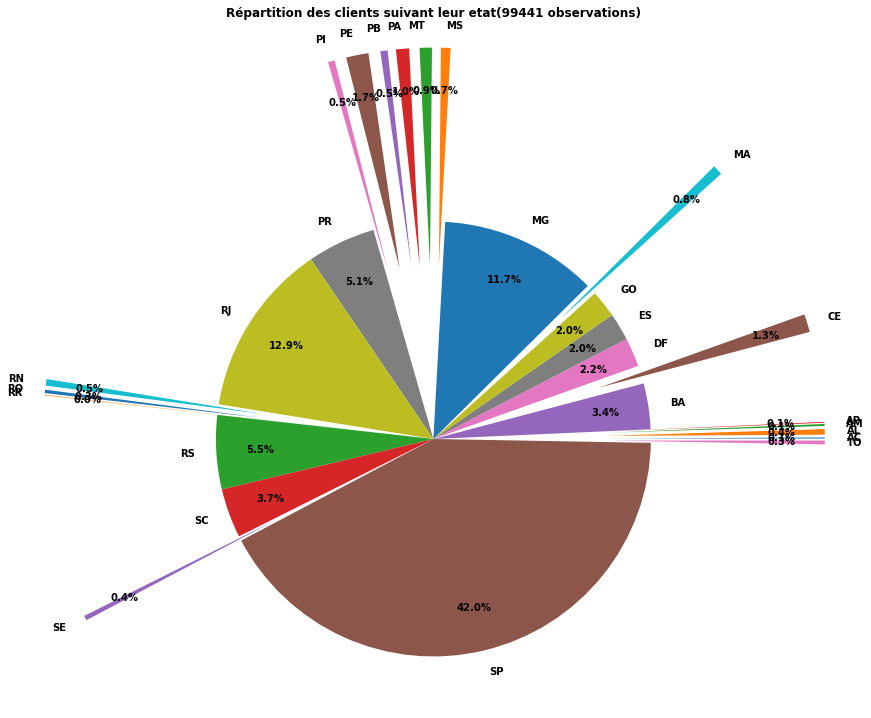

In [17]:
figure0 = plt.figure(figsize=(15, 10), facecolor='w')
x = data_customers['customer_state'].value_counts().sort_index()
plt.title(
    f'Répartition des clients suivant leur etat({x.sum()} observations)', pad=150, fontweight='bold')
plt.axis('off')
expl = [0 if i/x.sum() > 0.02 else 0.8 for i in x]
plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
        explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.show()

--> let's try a bar plot it could be more representative

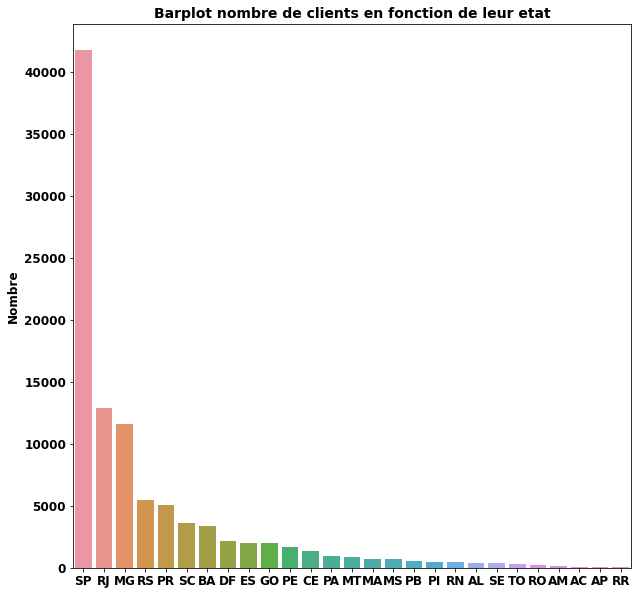

In [18]:
figure1 = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.weight': 'bold', 'font.size': 12})
plt.title(f'Barplot nombre de clients en fonction de leur etat',
          fontweight='bold', fontsize=14)
sns.barplot(x=data_customers['customer_state'].value_counts().index,
            y=data_customers['customer_state'].value_counts())
plt.ylabel('Nombre', fontweight='bold')
#plt.savefig('Répartition des clients par états.png', dpi=300)
plt.show()

### **Number of order by unique client**

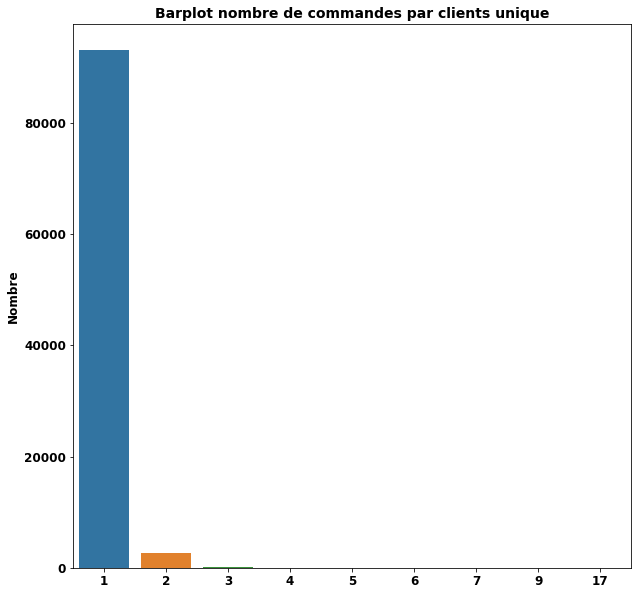

In [19]:
figure3 = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.weight': 'bold', 'font.size': 12})
plt.title(f'Barplot nombre de commandes par clients unique',
          fontweight='bold', fontsize=14)
sns.barplot(x=data_customers['customer_unique_id'].value_counts().sort_index().value_counts(
).index, y=data_customers['customer_unique_id'].value_counts().sort_index().value_counts())
plt.ylabel('Nombre', fontweight='bold')
#plt.savefig('Nombre de commande par clients.png', dpi=300)
plt.show()

--> Majority of the clients have only made 1 order... not very practical for the Frequency impact in an RFM

## **Passing briefely on other files**

### **Order informations**

In [20]:
data_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [166]:
data_orders['order_purchase_timestamp'] = pd.to_datetime(data_orders['order_purchase_timestamp']).dt.date
df_date_orders = data_orders.groupby('order_purchase_timestamp').agg(nb_order = ('order_id', pd.Series.count))
df_date_orders

,nb_order
order_purchase_timestamp,
2016-09-04,1
2016-09-05,1
2016-09-13,1
2016-09-15,1
2016-10-02,1
...,...
2018-09-29,1
2018-10-01,1
2018-10-03,1


In [167]:
df_date_orders.index = pd.to_datetime(df_date_orders.index)
df_date_orders = df_date_orders.groupby(pd.Grouper(freq="M")).sum()
df_date_orders

,nb_order
order_purchase_timestamp,
2016-09-30,4
2016-10-31,324
2016-11-30,0
2016-12-31,1
2017-01-31,800
2017-02-28,1780
2017-03-31,2682
2017-04-30,2404
2017-05-31,3700


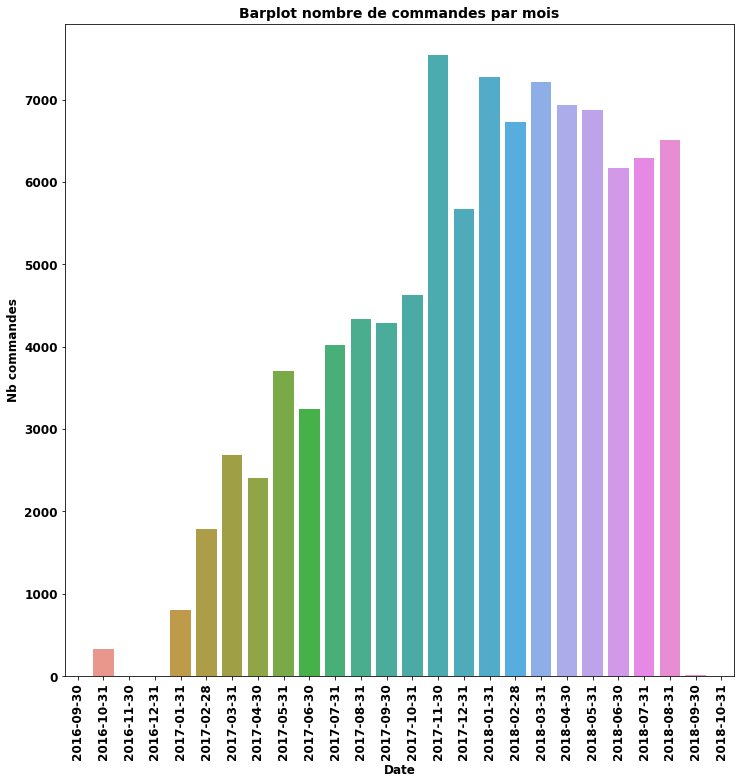

In [176]:
figure4 = plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.weight': 'bold', 'font.size': 12})
plt.title(f'Barplot nombre de commandes par mois',
          fontweight='bold', fontsize=14)
sns.barplot(x = (df_date_orders.index).date, y= df_date_orders['nb_order'])
plt.xticks(rotation=90)
plt.ylabel('Nb commandes', fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.savefig('Nombre de commande par date.png', dpi=300)
plt.show()

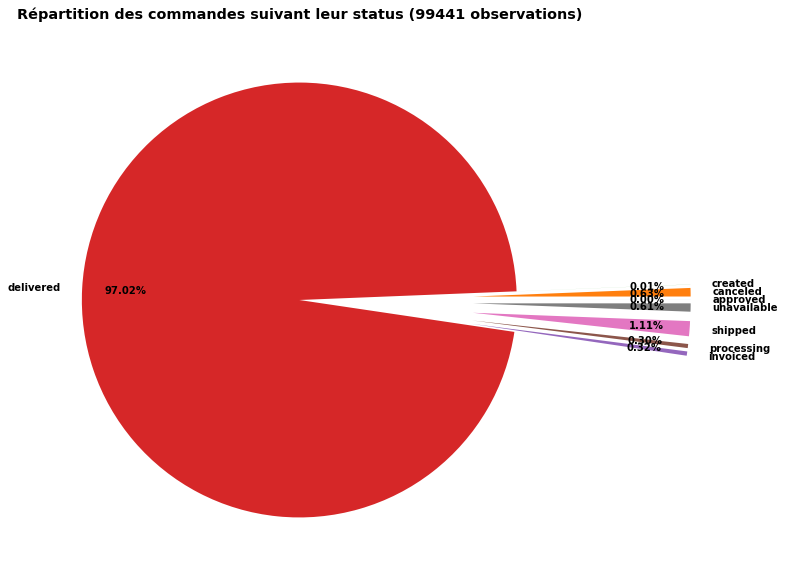

In [21]:
figure4 = plt.figure(figsize=(15, 10), facecolor='w')
x = data_orders['order_status'].value_counts().sort_index()
plt.title(
    f'Répartition des commandes suivant leur status ({x.sum()} observations)', pad=10, fontweight='bold')
plt.axis('off')
expl = [0 if i/x.sum() > 0.02 else 0.8 for i in x]
plt.pie(x, labels=[i for i in x.index], autopct="%.2f%%", pctdistance=0.8,
        explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.savefig('Répartition des commandes suivant leur status.png', dpi=300)
plt.show()

--> Majority of the order has been delivered. But we can see that 0.63% of them have been canceled, 0.61% are unavailable...etc. We should take that into acount later.<br/>
--> We will focus on all the order which have the status delivered (it meens for shure a client which have received their order).<br/>
--> Let's try to evaluate the shipping delai, it could be an interessant information

In [22]:
data_orders['shipping_delay_days'] = (pd.to_datetime(data_orders['order_delivered_customer_date']) - pd.to_datetime(
    data_orders['order_purchase_timestamp'])).dt.days

In [23]:
data_orders.loc[(data_orders['order_delivered_customer_date'].isnull())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_delay_days
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00,NaN
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,NaN
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00,NaN
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00,NaN
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00,NaN
...,...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,NaN
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00,NaN
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,NaN
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00,NaN


--> There is 2965 orders where we have no information about the delivery

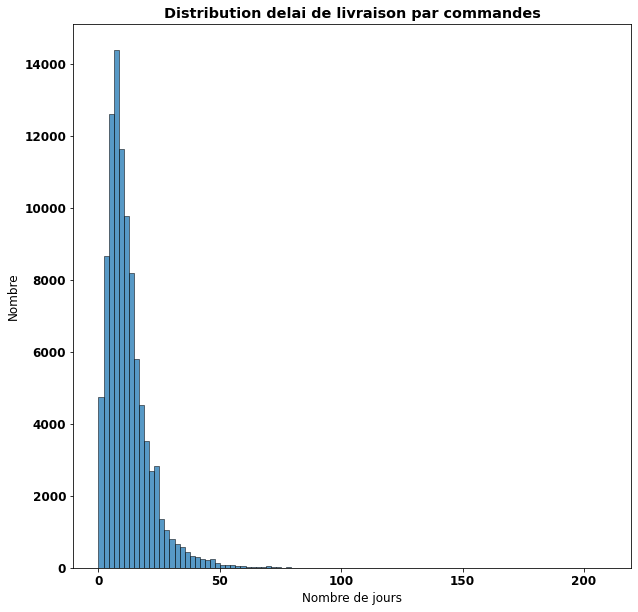

In [113]:
figure_4bis = plt.figure(figsize=(10, 10))
plt.title('Distribution delai de livraison par commandes', fontweight='bold')
sns.histplot(x='shipping_delay_days', data=data_orders, bins=100)
plt.xlabel('Nombre de jours')
plt.ylabel('Nombre')
plt.savefig('Distribution_delai_de_livraison.jpg',
            dpi=300, bbox_inches='tight')
plt.show()

### **Order payments informations**

In [25]:
data_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


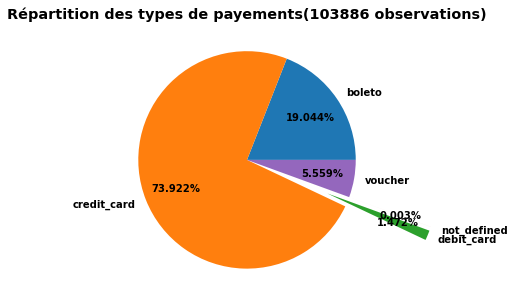

In [91]:
figure5 = plt.figure(figsize=(5, 5), facecolor='w')
x = data_order_payments['payment_type'].value_counts().sort_index()
plt.title(
    f'Répartition des types de payements({x.sum()} observations)', fontweight='bold')
plt.axis('off')
expl = [0 if i/x.sum() > 0.02 else 0.8 for i in x]
plt.pie(x, labels=[i for i in x.index], autopct="%.3f%%", pctdistance=0.7,
        explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.savefig('Répartitions des types de payments.png',
            dpi=300, bbox_inches='tight')
plt.show()

--> Essential of the payment are done by credit_card

In [27]:
df_order_infos = data_order_payments.groupby('order_id').agg(sequential=('payment_sequential', max), payment_value_total=(
    'payment_value', sum), payment_type=('payment_type', lambda x: {name: x.value_counts()[idx] for idx, name in enumerate(x.value_counts().index.tolist())}))
df_order_infos

,sequential,payment_value_total,payment_type
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,1,72.19,{'credit_card': 1}
00018f77f2f0320c557190d7a144bdd3,1,259.83,{'credit_card': 1}
000229ec398224ef6ca0657da4fc703e,1,216.87,{'credit_card': 1}
00024acbcdf0a6daa1e931b038114c75,1,25.78,{'credit_card': 1}
00042b26cf59d7ce69dfabb4e55b4fd9,1,218.04,{'credit_card': 1}
...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,343.40,{'boleto': 1}
fffcd46ef2263f404302a634eb57f7eb,1,386.53,{'boleto': 1}
fffce4705a9662cd70adb13d4a31832d,1,116.85,{'credit_card': 1}


--> let's try another method for the payment type (if we save in CSV, dict values will not be conserved)

In [28]:
df_order_infos_2 = data_order_payments.groupby('order_id').agg(sequential=('payment_sequential', max), payment_value_total=(
    'payment_value', sum), main_payment_type=('payment_type', lambda x: x.value_counts().index[0]))
df_order_infos_2

,sequential,payment_value_total,main_payment_type
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,1,72.19,credit_card
00018f77f2f0320c557190d7a144bdd3,1,259.83,credit_card
000229ec398224ef6ca0657da4fc703e,1,216.87,credit_card
00024acbcdf0a6daa1e931b038114c75,1,25.78,credit_card
00042b26cf59d7ce69dfabb4e55b4fd9,1,218.04,credit_card
...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,343.40,boleto
fffcd46ef2263f404302a634eb57f7eb,1,386.53,boleto
fffce4705a9662cd70adb13d4a31832d,1,116.85,credit_card


In [29]:
data_order_payments.loc[data_order_payments['order_id']
                        == '0bbb3f7791a87d0307555e57da3a1ff1']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
2685,0bbb3f7791a87d0307555e57da3a1ff1,7,voucher,1,14.92
23387,0bbb3f7791a87d0307555e57da3a1ff1,2,voucher,1,2.41
31570,0bbb3f7791a87d0307555e57da3a1ff1,3,voucher,1,2.39
39298,0bbb3f7791a87d0307555e57da3a1ff1,11,voucher,1,21.68
42371,0bbb3f7791a87d0307555e57da3a1ff1,10,voucher,1,7.58
49652,0bbb3f7791a87d0307555e57da3a1ff1,4,voucher,1,2.58
53334,0bbb3f7791a87d0307555e57da3a1ff1,6,voucher,1,1.55
71125,0bbb3f7791a87d0307555e57da3a1ff1,5,voucher,1,2.58
73354,0bbb3f7791a87d0307555e57da3a1ff1,8,voucher,1,1.88
92290,0bbb3f7791a87d0307555e57da3a1ff1,1,credit_card,7,76.20


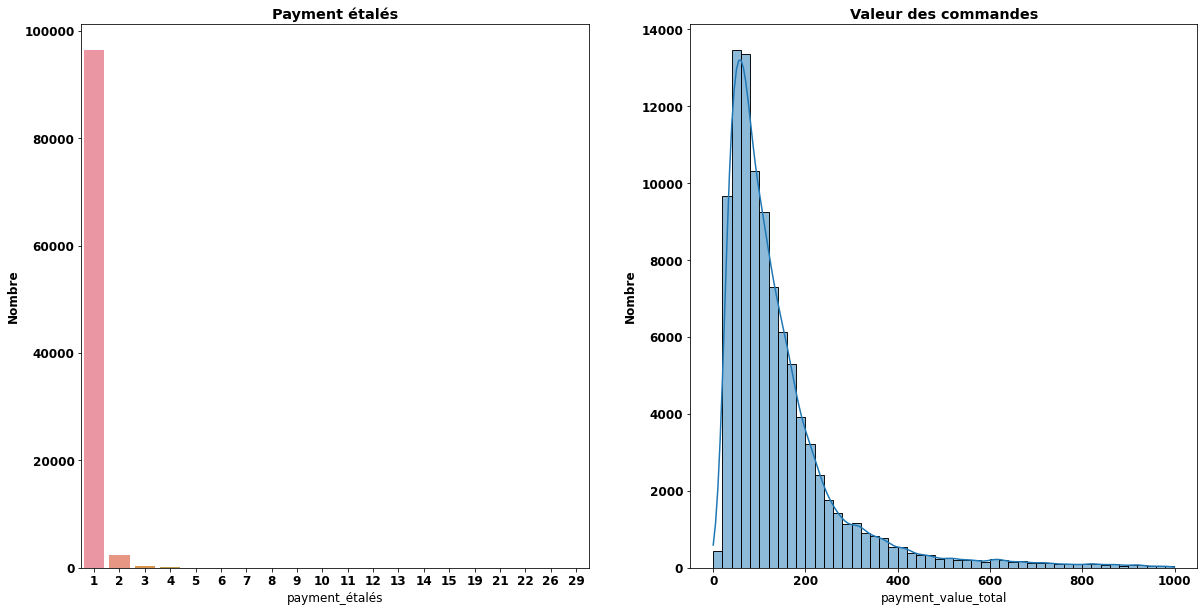

In [107]:
figure6 = plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.weight': 'bold', 'font.size': 12})
figure6.add_subplot(1, 2, 1)
plt.title('Payment étalés', fontweight='bold')
sns.barplot(x=df_order_infos['sequential'].value_counts().sort_index().index,
            y=df_order_infos['sequential'].value_counts().sort_index())
plt.xlabel('payment_étalés')
plt.ylabel('Nombre', fontweight='bold')
figure6.add_subplot(1, 2, 2)
plt.title('Valeur des commandes', fontweight='bold')
sns.histplot(
    data=df_order_infos.loc[df_order_infos['payment_value_total'] < 1000]['payment_value_total'], bins=50, kde=True)
plt.ylabel('Nombre', fontweight='bold')
plt.savefig('Payment étalés et valeurs des commandes.png', dpi=300)
plt.show()

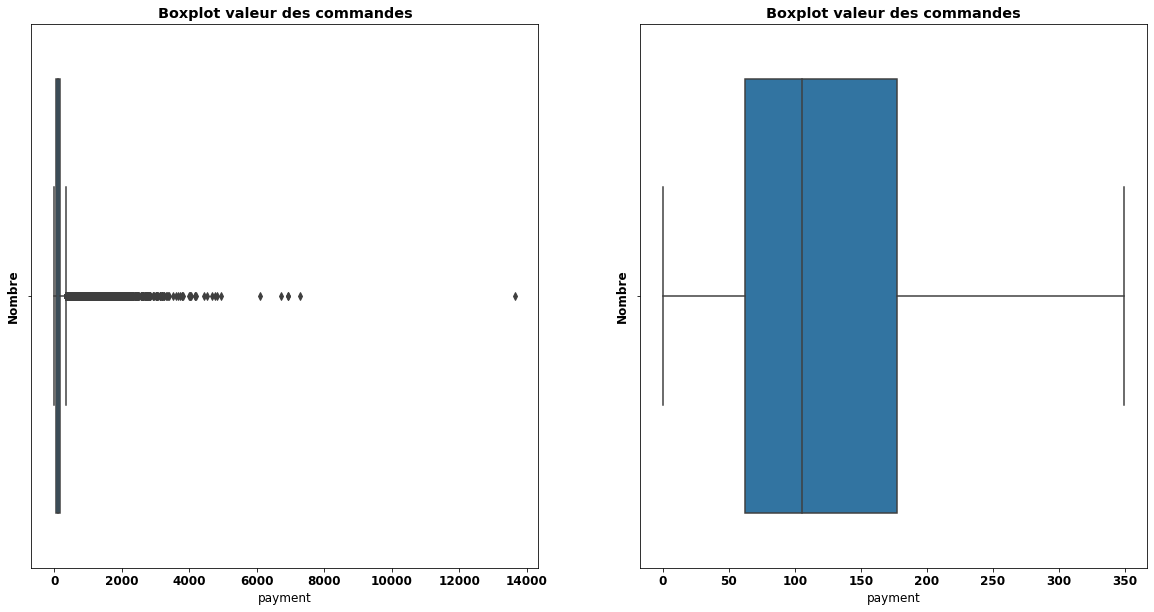

In [109]:
figure6bis = plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.weight': 'bold', 'font.size': 12})
figure6bis.add_subplot(1, 2, 1)
plt.title('Boxplot valeur des commandes', fontweight='bold')
sns.boxplot(x=df_order_infos['payment_value_total'])
plt.xlabel('payment')
plt.ylabel('Nombre', fontweight='bold')
figure6bis.add_subplot(1, 2, 2)
plt.title('Boxplot valeur des commandes', fontweight='bold')
sns.boxplot(x=df_order_infos['payment_value_total'], showfliers=False)
plt.xlabel('payment')
plt.ylabel('Nombre', fontweight='bold')
plt.savefig('Box_plot valeurs des commandes.png', dpi=300)
plt.show()

--> Essential of the order are payed in one time or 2 <br/>
--> the essential of the sum payed are beteween 100 and 250... We may already have a group of people over 1000-2000 the order which could be already set appart for later?

### **Order items informations**

In [32]:
data_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [33]:
data_order_items['seller_id'].nunique()

3095

--> There is 3095 different sellers in this dataset

In [38]:
data_order_items['product_id'].nunique()

32951

--> There is 32951 different products in this dataset

In [39]:
testx = data_order_items.loc[data_order_items['order_id'] ==
                             '8272b63d03f5f79c56e9e4120aec44ef']['product_id'].value_counts()

In [40]:
test = {v: testx[k] for k, v in enumerate(testx.index.tolist())}
test

{'270516a3f41dc035aa87d220228f844c': 10,
 '05b515fdc76e888aada3c6d66c201dff': 10,
 '79ce45dbc2ea29b22b5a261bbb7b7ee7': 1}

In [41]:
df_order_item_infos = data_order_items.groupby('order_id').agg(product_number=('order_item_id', pd.Series.count), different_product=(
    'product_id', pd.Series.nunique), dico_product=('product_id', lambda x: {name: x.value_counts()[idx] for idx, name in enumerate(x.value_counts().index.tolist())}),
    seller_number=('seller_id', pd.Series.nunique), sellers_id=('seller_id', pd.Series.unique))

In [37]:
df_order_item_infos

,product_number,different_product,dico_product,seller_number,sellers_id
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,1,{'4244733e06e7ecb4970a6e2683c13e61': 1},1,48436dade18ac8b2bce089ec2a041202
00018f77f2f0320c557190d7a144bdd3,1,1,{'e5f2d52b802189ee658865ca93d83a8f': 1},1,dd7ddc04e1b6c2c614352b383efe2d36
000229ec398224ef6ca0657da4fc703e,1,1,{'c777355d18b72b67abbeef9df44fd0fd': 1},1,5b51032eddd242adc84c38acab88f23d
00024acbcdf0a6daa1e931b038114c75,1,1,{'7634da152a4610f1595efa32f14722fc': 1},1,9d7a1d34a5052409006425275ba1c2b4
00042b26cf59d7ce69dfabb4e55b4fd9,1,1,{'ac6c3623068f30de03045865e4e10089': 1},1,df560393f3a51e74553ab94004ba5c87
...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,1,{'4aa6014eceb682077f9dc4bffebc05b0': 1},1,b8bc237ba3788b23da09c0f1f3a3288c
fffcd46ef2263f404302a634eb57f7eb,1,1,{'32e07fd915822b0765e448c4dd74c828': 1},1,f3c38ab652836d21de61fb8314b69182
fffce4705a9662cd70adb13d4a31832d,1,1,{'72a30483855e2eafc67aee5dc2560482': 1},1,c3cfdc648177fdbbbb35635a37472c53


--> we have less order id as in the payment informations (maybe some order have not been payed?) 

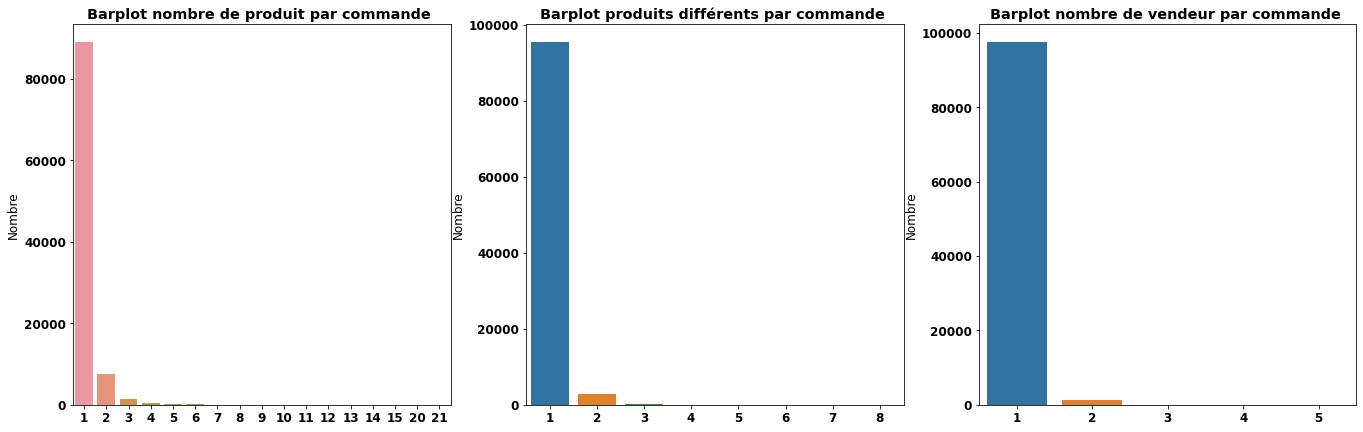

In [42]:
figure7 = plt.figure(figsize=(23, 7), facecolor='w')
dico_name = {'product_number': 'nombre de produit par commande', 'different_product':
             'produits différents par commande', 'seller_number': 'nombre de vendeur par commande'}
count = 1
for name in ['product_number', 'different_product', 'seller_number']:
    figure7.add_subplot(1, 3, count)
    plt.title(f'Barplot {dico_name[name]} ', fontweight='bold')
    sns.barplot(x=df_order_item_infos[name].value_counts().sort_index(
    ).index, y=df_order_item_infos[name].value_counts().sort_index())
    plt.ylabel('Nombre')
    count += 1
plt.savefig('Informations par commandes.png', dpi=300)
plt.show()

--> Essentially we have 1 product by order and one seller...

### **Order reviews informations**

In [43]:
data_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [44]:
data_order_reviews['review_id'].nunique()

99173

In [45]:
data_order_reviews['order_id'].nunique()

99441

--> there is more order_id than reviews, we may have several reviews for an order!

columns with first values is review_id and columns with last value is review_answer_timestamp
There is 79.06685714285715 percent of values available in the Dataframe, available data above 0 percent have been kept


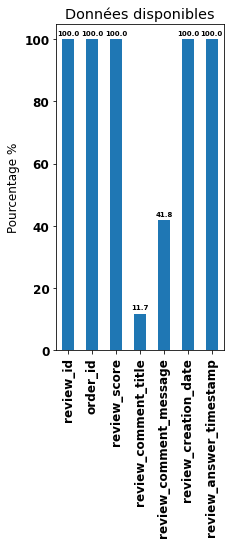

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [46]:
columnsDataAvailable(data_order_reviews, 0)

--> all order in the datfile have a review note! It could be an interesting information for later <br/>
--> We can underline the format of the date for the 'review creation date', the hour is 00.00.00?

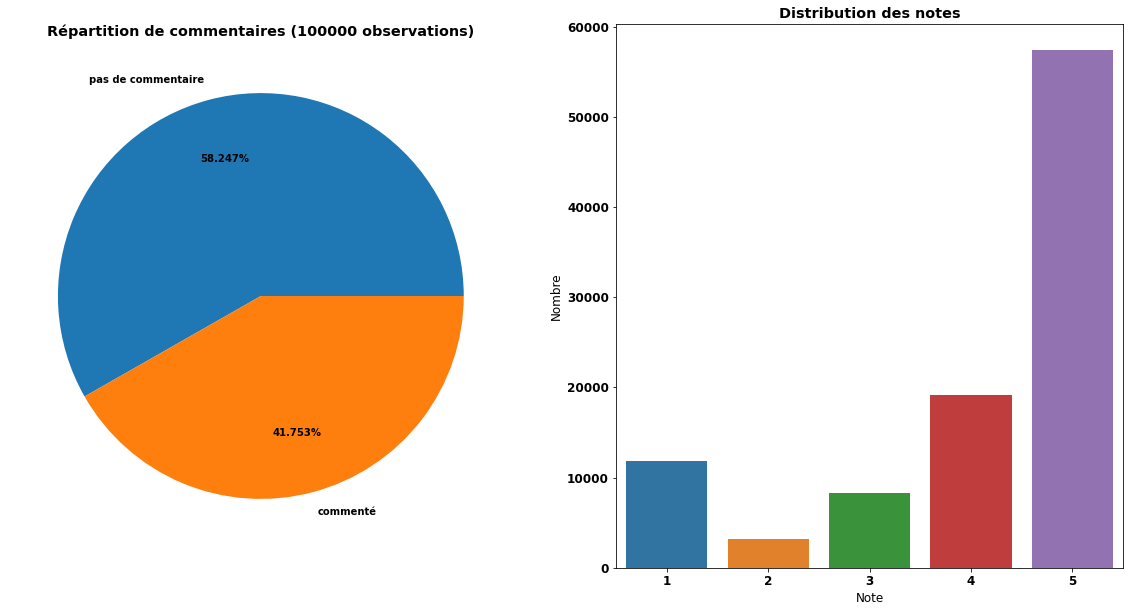

In [47]:
figure8 = plt.figure(figsize=(20, 10), facecolor='w')
figure8.add_subplot(1, 2, 1)
x = data_order_reviews['review_comment_message'].apply(
    lambda x: 1 if type(x) == type('str') else 0).value_counts()
plt.title(
    f'Répartition de commentaires ({x.sum()} observations)', fontweight='bold')
plt.axis('off')
expl = [0 if i/x.sum() > 0.02 else 0.8 for i in x]
plt.pie(x, labels=['pas de commentaire', 'commenté'], autopct="%.3f%%", pctdistance=0.7,
        explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'})
figure8.add_subplot(1, 2, 2)
plt.title('Distribution des notes', fontweight='bold')
sns.barplot(x=data_order_reviews['review_score'].value_counts().sort_index(
).index, y=data_order_reviews['review_score'].value_counts().sort_index())
plt.ylabel('Nombre')
plt.xlabel('Note')
plt.savefig('Review_informations.png', dpi=300)
plt.show()

In [48]:
data_order_reviews['review_creation_date'] = pd.to_datetime(
    data_order_reviews['review_creation_date'])

In [49]:
data_order_reviews.sort_values('review_creation_date', inplace=True)

In [50]:
df_order_reviews_infos = data_order_reviews.groupby('order_id').agg(review_number=(
    'review_id', pd.Series.count), last_review_score=('review_score', lambda x: x.tail(1)))
df_order_reviews_infos

,review_number,last_review_score
order_id,,
00010242fe8c5a6d1ba2dd792cb16214,1,5
00018f77f2f0320c557190d7a144bdd3,1,4
000229ec398224ef6ca0657da4fc703e,1,5
00024acbcdf0a6daa1e931b038114c75,1,4
00042b26cf59d7ce69dfabb4e55b4fd9,1,5
...,...,...
fffc94f6ce00a00581880bf54a75a037,1,5
fffcd46ef2263f404302a634eb57f7eb,1,5
fffce4705a9662cd70adb13d4a31832d,1,5


In [51]:
df_order_reviews_infos.rename(columns={
                              'review_number': 'order_review_number', 'last_review_score': 'order_last_review_score'}, inplace=True)

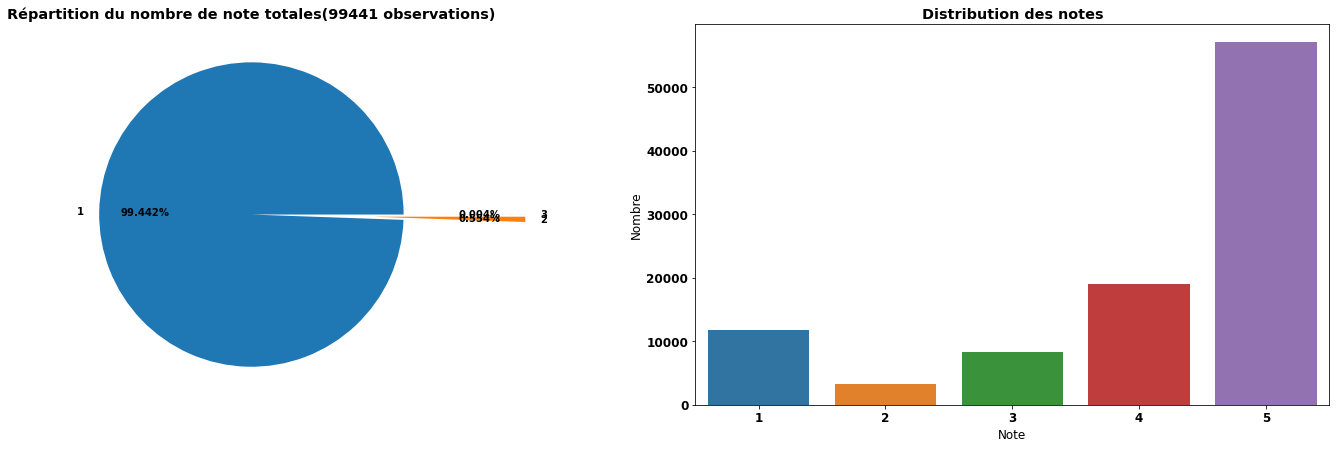

In [52]:
figure9 = plt.figure(figsize=(25, 7), facecolor='w')
figure9.add_subplot(1, 2, 1)
x = df_order_reviews_infos['order_review_number'].value_counts().sort_index()
plt.title(
    f'Répartition du nombre de note totales({x.sum()} observations)', fontweight='bold')
plt.axis('off')
expl = [0 if i/x.sum() > 0.02 else 0.8 for i in x]
plt.pie(x, labels=x.index, autopct="%.3f%%", pctdistance=0.7,
        explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'})
figure9.add_subplot(1, 2, 2)
plt.title('Distribution des notes', fontweight='bold')
sns.barplot(x=df_order_reviews_infos['order_last_review_score'].value_counts().sort_index(
).index, y=df_order_reviews_infos['order_last_review_score'].value_counts().sort_index())
plt.ylabel('Nombre')
plt.xlabel('Note')
plt.show()

--> there is not a lot of review score update on the different order <br/>
--> By taking only the last review score assigned to an order we have the same patern of the distribution of the score (we can keep in mind this information for later)

### **Products informations (2 files products and category)**

In [53]:
data_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [54]:
data_products['product_id'].duplicated().sum()

0

--> there is no duplicate in the product dataset

In [55]:
data_categ.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


--> let's transform our category in the english description with a dictionnary (some category may not figure in the file category we want to keep them without modifications)

In [56]:
dico_category = {VO: VE for VO, VE in zip(
    data_categ['product_category_name'], data_categ['product_category_name_english'])}
data_products['english_translation_if_find'] = data_products['product_category_name'].apply(
    lambda x: dico_category.get(x) if dico_category.get(x) != None else x)

In [57]:
data_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,english_translation_if_find
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


--> lets merge products with order items data to visualize the products purchase distributions

In [58]:
data_order_product = pd.merge(data_order_items, data_products, on='product_id')
data_order_product

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,english_translation_if_find
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,ffebd80e3291e811c308365936897efd,1,4cc4d02efc8f249c13355147fb44e34d,d1c7fa84e48cfa21a0e595167c1c500e,2018-07-18 20:23:55,129.9,51.20,ferramentas_jardim,37.0,653.0,1.0,6700.0,35.0,12.0,22.0,garden_tools
112646,ffee31fb4b5e35c9123608015637c495,1,b10ecf8e33aaaea419a9fa860ea80fb5,0241d4d5d36f10f80c644447315af0bd,2018-08-21 10:10:11,99.0,13.52,moveis_decoracao,30.0,308.0,1.0,2300.0,37.0,30.0,20.0,furniture_decor
112647,fff7c4452f050315db1b3f24d9df5fcd,1,dd469c03ad67e201bc2179ef077dcd48,7e93a43ef30c4f03f38b393420bc753a,2017-06-07 17:05:23,736.0,20.91,relogios_presentes,33.0,658.0,3.0,400.0,19.0,9.0,15.0,watches_gifts
112648,fffa82886406ccf10c7b4e35c4ff2788,1,bbe7651fef80287a816ead73f065fc4b,8f2ce03f928b567e3d56181ae20ae952,2017-12-22 17:31:42,229.9,44.02,esporte_lazer,32.0,280.0,2.0,2700.0,60.0,15.0,15.0,sports_leisure


columns with first values is product_id and columns with last value is english_translation_if_find
There is 99.07195532760767 percent of values available in the Dataframe, available data above 0 percent have been kept


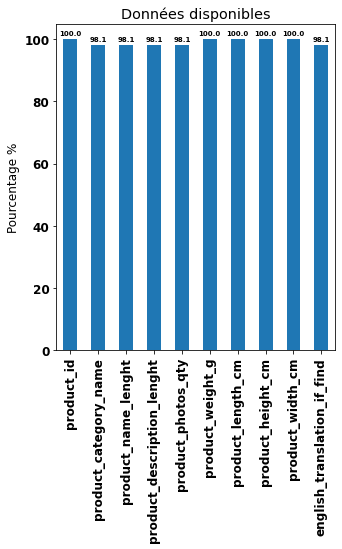

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,english_translation_if_find
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


In [59]:
columnsDataAvailable(data_products, 0)

In [60]:
data_products.rename(
    columns={'english_translation_if_find': 'category_name'}, inplace=True)
data_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


--> Important to noticed, some products are not identified in category and some of their caractheristic are not available <br/>
--> Let's try to visualize the best categories of products sold and the best products sold

In [61]:
df_cat = data_order_product.groupby('english_translation_if_find').agg(
    nombre_de_produits=('english_translation_if_find', pd.Series.count))
df_prod = data_order_product.groupby('product_id').agg(nombre_de_produits=(
    'product_category_name', pd.Series.count), categorie=('english_translation_if_find', pd.Series.unique))

In [62]:
df_cat

,nombre_de_produits
english_translation_if_find,
agro_industry_and_commerce,212
air_conditioning,297
art,209
arts_and_craftmanship,24
audio,364
...,...
stationery,2517
tablets_printing_image,83
telephony,4545


In [63]:
df_prod

,nombre_de_produits,categorie
product_id,,
00066f42aeeb9f3007548bb9d3f33c38,1,perfumery
00088930e925c41fd95ebfe695fd2655,1,auto
0009406fd7479715e4bef61dd91f2462,1,bed_bath_table
000b8f95fcb9e0096488278317764d19,2,housewares
000d9be29b5207b54e86aa1b1ac54872,1,watches_gifts
...,...,...
fff6177642830a9a94a0f2cba5e476d1,2,cool_stuff
fff81cc3158d2725c0655ab9ba0f712c,1,health_beauty
fff9553ac224cec9d15d49f5a263411f,1,fashion_bags_accessories


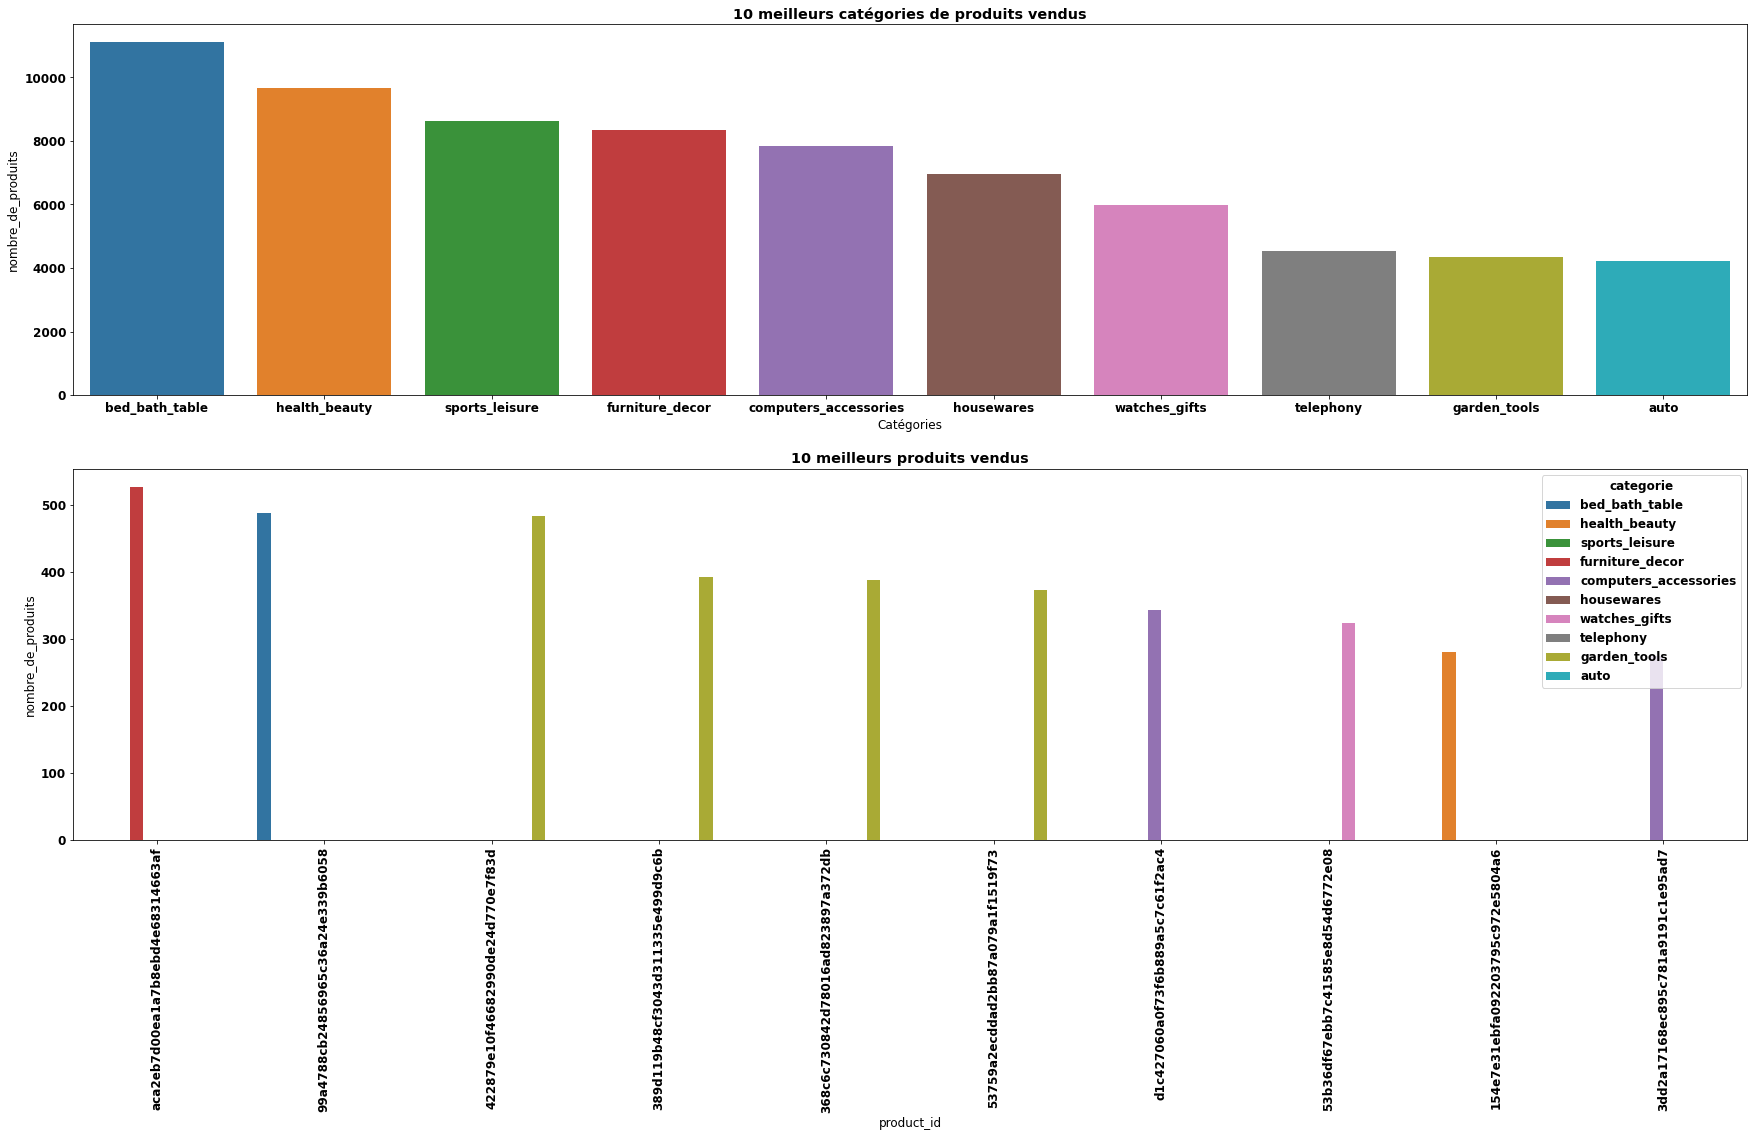

In [64]:
figure10 = plt.figure(figsize=(30, 15))
figure10.add_subplot(2, 1, 1)
plt.title('10 meilleurs catégories de produits vendus', fontweight='bold')
data = df_cat.sort_values('nombre_de_produits', ascending=False).head(10)
sns.barplot(x=data.index, y=data['nombre_de_produits'])
plt.xlabel('Catégories')
legend_c = data.index
figure10.add_subplot(2, 1, 2)
data = df_prod.sort_values('nombre_de_produits', ascending=False).head(10)
plt.title('10 meilleurs produits vendus', fontweight='bold')
sns.barplot(
    x=data.index, y=data['nombre_de_produits'], data=data, hue='categorie', hue_order=legend_c)
plt.xticks(rotation=90)
plt.savefig('Categories et produits informations.png', dpi=300)
plt.show()

### **Products sellers**

In [65]:
data_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [66]:
data_sellers.duplicated().sum()

0

--> There is no duplicate sellers in our data

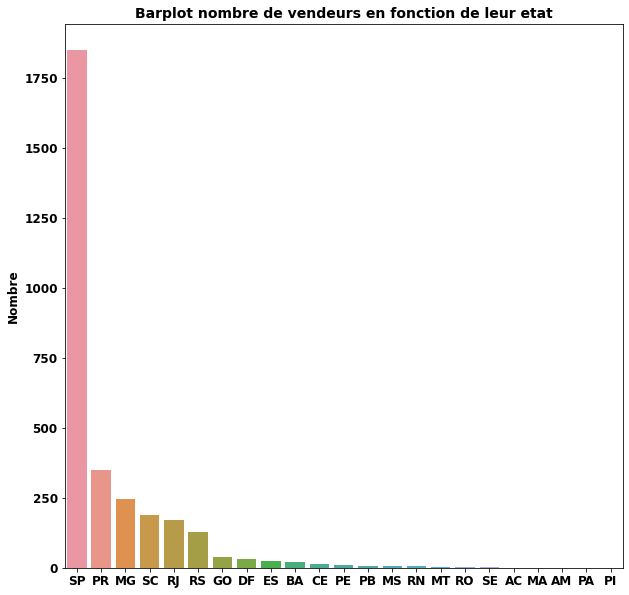

In [67]:
figure11 = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.weight': 'bold', 'font.size': 12})
plt.title(f'Barplot nombre de vendeurs en fonction de leur etat',
          fontweight='bold', fontsize=14)
sns.barplot(x=data_sellers['seller_state'].value_counts().index,
            y=data_sellers['seller_state'].value_counts())
plt.ylabel('Nombre', fontweight='bold')
plt.savefig('Répartition des vendeurs par état.png', dpi=300)
plt.show()

--> In conclusion we have not a lot informations about the profil of the clients (RFM information would be a base to evaluate) <br/>
--> Informations about location, delivery shipping date and interest will be a plus to analyse for each customer.<br/>
--> Regarding order it is where we can add information (i think): we could find some information that we could linked to a customer <br/>
    Therefore we will try to gathered information about the number of articles purchase/what articles have been purchase and to which seller.<br/>
--> Date of purchase will be used to create period of time dataset.<br/>
--> Order that have not shipping delay will be drop of our study

## **Creating a global dataset**

### **Merging files**

--> Changing columns name in some files to concatenate later (zip_code_prefix)

In [68]:
data_customers.rename(
    columns={'customer_zip_code_prefix': 'zip_code_prefix'}, inplace=True)
data_geo.rename(
    columns={'geolocation_zip_code_prefix': 'zip_code_prefix'}, inplace=True)

--> Merge of customers and geo files

In [69]:
data_geo.drop_duplicates('zip_code_prefix', inplace=True)
df_data_global_olist = pd.merge(
    data_customers, data_geo, on='zip_code_prefix', how='left')
df_data_global_olist.drop_duplicates(inplace=True)
df_data_global_olist

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP
...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.956391,-51.167614,canoas,RS


columns with first values is customer_id and columns with last value is geolocation_state
There is 99.87574988630891 percent of values available in the Dataframe, available data above 0 percent have been kept


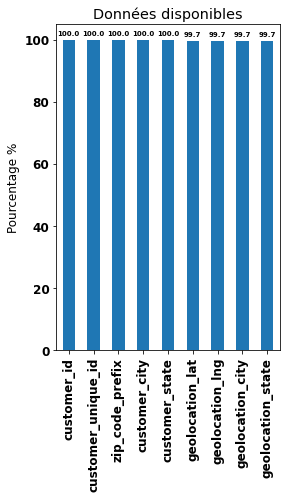

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP
...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.956391,-51.167614,canoas,RS


In [70]:
columnsDataAvailable(df_data_global_olist, 0)

In [71]:
df_data_global_olist.loc[df_data_global_olist['geolocation_lat'].isnull()]

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
354,ecb1725b26e8b8c458181455dfa434ea,b55a113bb84fc10eaf58c6d09ec69794,72300,brasilia,DF,NaN,NaN,NaN,NaN
382,bcf86029aeed4ed8bac0e16eb14c22f5,7cd7974c9f79f75b77f323878ef87f43,11547,cubatao,SP,NaN,NaN,NaN,NaN
877,f4302056f0c58570522590f8181de2c7,67b05b597a66b5c449025000b9430abb,64605,picos,PI,NaN,NaN,NaN,NaN
1218,03bbe0ce5c28e05f22917607db798818,8f3dca4306d5a89e4ae2c65c110603a2,72465,brasilia,DF,NaN,NaN,NaN,NaN
1272,ad4950aded55c2ea376be59506456d68,aa2b96dd03307ea6dc4b763c0b5f0b39,7729,caieiras,SP,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
97467,cf818420383856a129134f5f8343f7b8,795c495a65f983b242fb01bd507977c5,72338,brasilia,DF,NaN,NaN,NaN,NaN
97780,67f3e907dce402e696b15f9308ff22ed,6f232f2f5c7f33b7bd9d794d2afacadd,68629,paragominas,PA,NaN,NaN,NaN,NaN
98140,f792e419335df11d82c32efcfb09c51b,c04c085b8e7573ba87b9ae1968d0985e,28530,sao sebastiao do paraiba,RJ,NaN,NaN,NaN,NaN
98878,78a11bb1fa72f556996b9a5b9bcd0629,e7536f62a200b415edd9491ac12a17fa,55863,siriji,PE,NaN,NaN,NaN,NaN


--> There is 278 clients where we have not the geolocalisation informations

In [68]:
df_data_global_olist.dropna(subset=['geolocation_lat'], inplace=True)
df_data_global_olist.drop(
    labels=['geolocation_city', 'geolocation_state'], axis=1, inplace=True)
df_data_global_olist.shape

(99163, 7)

--> let's merge with order, order_items, order_payments then order review with data create before and finally sellers data

In [72]:
df_data_global_olist = pd.merge(df_data_global_olist, data_orders[[
                                'customer_id', 'order_id', 'order_status', 'order_purchase_timestamp', 'order_delivered_customer_date', 'shipping_delay_days']], on='customer_id', how='left')
df_data_global_olist

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,shipping_delay_days
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,6.0
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,7.0
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,30.0
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.956391,-51.167614,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-16 19:58:39,12.0


--> Merging with order payment informations (gathered by order)

In [73]:
df_data_global_olist = pd.merge(df_data_global_olist, df_order_infos_2[[
                                'sequential', 'payment_value_total', 'main_payment_type']], right_index=True, left_on='order_id', how='left')
df_data_global_olist

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,shipping_delay_days,sequential,payment_value_total,main_payment_type
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,1.0,146.87,credit_card
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,1.0,335.48,credit_card
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,1.0,157.73,credit_card
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,1.0,173.30,credit_card
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,1.0,252.25,credit_card
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,6.0,1.0,88.78,credit_card
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,7.0,1.0,129.06,credit_card
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,30.0,1.0,56.04,credit_card
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.956391,-51.167614,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-16 19:58:39,12.0,1.0,711.07,credit_card


--> let's merge with order items data (including informations about products in orders)

In [74]:
df_data_global_olist = pd.merge(df_data_global_olist, data_order_items[[
                                'order_id', 'order_item_id', 'product_id', 'seller_id', 'price', 'freight_value']], on='order_id', how='left')
df_data_global_olist

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,shipping_delay_days,sequential,payment_value_total,main_payment_type,order_item_id,product_id,seller_id,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,1.0,146.87,credit_card,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,1.0,335.48,credit_card,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,1.0,157.73,credit_card,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,1.0,173.30,credit_card,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,1.0,252.25,credit_card,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,6.0,1.0,88.78,credit_card,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,74.90,13.88
113421,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,7.0,1.0,129.06,credit_card,1.0,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,114.90,14.16
113422,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,30.0,1.0,56.04,credit_card,1.0,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,37.00,19.04
113423,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.956391,-51.167614,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-16 19:58:39,12.0,1.0,711.07,credit_card,1.0,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,689.00,22.07


--> let's merge with order reviews data (gathered by order)

In [75]:
df_data_global_olist = pd.merge(
    df_data_global_olist, df_order_reviews_infos, right_index=True, left_on='order_id', how='left')
df_data_global_olist

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,shipping_delay_days,sequential,payment_value_total,main_payment_type,order_item_id,product_id,seller_id,price,freight_value,order_review_number,order_last_review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,1.0,146.87,credit_card,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,1,4
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,1.0,335.48,credit_card,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,289.00,46.48,1,5
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,1.0,157.73,credit_card,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,1,5
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,1.0,173.30,credit_card,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,1,5
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,1.0,252.25,credit_card,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,230.00,22.25,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,6.0,1.0,88.78,credit_card,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,74.90,13.88,1,4
113421,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,7.0,1.0,129.06,credit_card,1.0,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,114.90,14.16,1,5
113422,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,30.0,1.0,56.04,credit_card,1.0,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,37.00,19.04,1,1
113423,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.956391,-51.167614,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-16 19:58:39,12.0,1.0,711.07,credit_card,1.0,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,689.00,22.07,1,5


--> let's merge with data product (add specific information by products purchased)

In [76]:
df_data_global_olist = pd.merge(df_data_global_olist, data_products[[
                                'product_id', 'category_name']], on='product_id', how='left')
df_data_global_olist

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,shipping_delay_days,sequential,payment_value_total,main_payment_type,order_item_id,product_id,seller_id,price,freight_value,order_review_number,order_last_review_score,category_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,1.0,146.87,credit_card,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,1,4,office_furniture
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,1.0,335.48,credit_card,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,289.00,46.48,1,5,housewares
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,1.0,157.73,credit_card,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,1,5,office_furniture
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,1.0,173.30,credit_card,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,1,5,office_furniture
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,1.0,252.25,credit_card,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,230.00,22.25,1,5,home_confort
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,6.0,1.0,88.78,credit_card,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,74.90,13.88,1,4,books_general_interest
113421,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,7.0,1.0,129.06,credit_card,1.0,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,114.90,14.16,1,5,sports_leisure
113422,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,30.0,1.0,56.04,credit_card,1.0,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,37.00,19.04,1,1,health_beauty
113423,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.956391,-51.167614,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-16 19:58:39,12.0,1.0,711.07,credit_card,1.0,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,689.00,22.07,1,5,watches_gifts


--> Adding location information of the sellers to evaluate distance with customer (calcul by function)

In [77]:
# evaluation of latitude and longitude for the sellers
data_geo_s = data_geo.rename(
    columns={'zip_code_prefix': 'seller_zip_code_prefix'})
df_geo_sellers = pd.merge(
    data_sellers, data_geo_s, on='seller_zip_code_prefix', how='left')
df_geo_sellers.rename(columns={'geolocation_lat': 'geolocation_lat_seller',
                      'geolocation_lng': 'geolocation_lng_seller'}, inplace=True)

# merge with our global file
df_data_global_olist = pd.merge(
    df_data_global_olist, df_geo_sellers, on='seller_id', how='left')

--> Creating a function to evaluate the distance between customers and sellers for each products in order and apply it

In [78]:
def approx_distance_km(latC, longC, latS, longS):
    '''Function to evaluate approximatively the distance in km between the customer and the seller
    it takes angles in degrees!!!! Numpy library is needed to use this function!!!
    latC and longC --> coordonate for the customer
    latS and longS --> coordonate for the seller'''
    # conversion of the angle in radian
    latC = np.radians(latC)
    longC = np.radians(longC)
    latS = np.radians(latS)
    longS = np.radians(longS)
    # Earth radius in km
    RT = 6378
    # Radian angle between the two points
    S = np.arccos(np.sin(latC)*np.sin(latS) + np.cos(latC)
                  * np.cos(latS)*np.cos(abs(longS-longC)))
    return S*RT

In [79]:
df_data_global_olist['distance_km_customer_seller'] = df_data_global_olist.apply(lambda x: approx_distance_km(
    x['geolocation_lat'], x['geolocation_lng'], x['geolocation_lat_seller'], x['geolocation_lng_seller']), axis=1)
df_data_global_olist

<ipython-input-78-cfc999268f40>:14: RuntimeWarning: invalid value encountered in arccos
  S = np.arccos(np.sin(latC)*np.sin(latS) + np.cos(latC)


,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city_x,geolocation_state_x,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,shipping_delay_days,sequential,payment_value_total,main_payment_type,order_item_id,product_id,seller_id,price,freight_value,order_review_number,order_last_review_score,category_name,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_y,geolocation_state_y,distance_km_customer_seller
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,1.0,146.87,credit_card,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,1,4,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,347.358827
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,1.0,335.48,credit_card,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,289.00,46.48,1,5,housewares,88303.0,itajai,SC,-26.912429,-48.677381,itajai,SC,414.407912
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,1.0,157.73,credit_card,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,1,5,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,29.606634
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,1.0,173.30,credit_card,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,1,5,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,19.375066
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,1.0,252.25,credit_card,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,230.00,22.25,1,5,home_confort,14940.0,ibitinga,SP,-21.766477,-48.831547,ibitinga,SP,219.968048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,6.0,1.0,88.78,credit_card,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,74.90,13.88,1,4,books_general_interest,17400.0,garca,SP,-22.218989,-49.643623,garca,SP,356.367892
113421,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,7.0,1.0,129.06,credit_card,1.0,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,114.90,14.16,1,5,sports_leisure,14802.0,araraquara,SP,-21.760806,-48.172285,araraquara,SP,251.678468
113422,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,30.0,1.0,56.04,credit_card,1.0,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,37.00,19.04,1,1,health_beauty,3304.0,sao paulo,SP,-23.544897,-46.577772,sao paulo,SP,2368.717679
113423,56b18e2

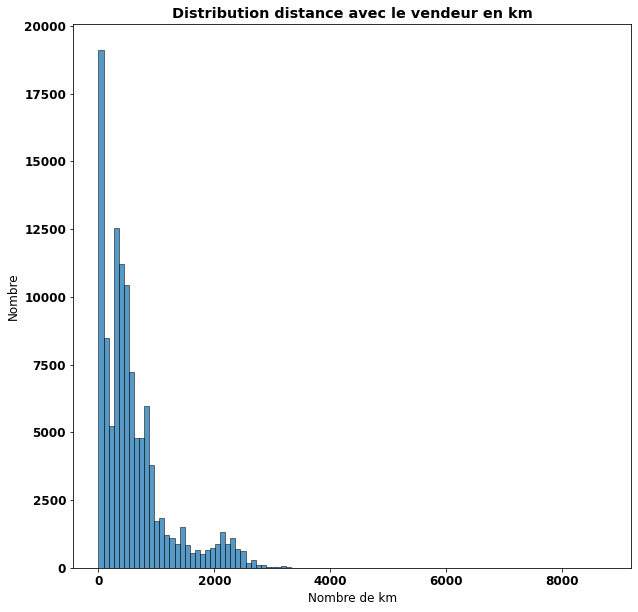

In [112]:
figure_12 = plt.figure(figsize=(10, 10))
plt.title('Distribution distance avec le vendeur en km', fontweight='bold')
sns.histplot(x='distance_km_customer_seller',
             data=df_data_global_olist, bins=100)
plt.xlabel('Nombre de km')
plt.ylabel('Nombre')
plt.savefig('Distribution distance.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> let's get rid of the order with no shipping delay available, no distance information with the seller and canceled orders

In [123]:
# last data filtering
df_data_global_olist_final = df_data_global_olist.dropna(
    subset=['shipping_delay_days', 'distance_km_customer_seller'])
df_data_global_olist_final = df_data_global_olist_final.loc[~(
    df_data_global_olist_final['order_status'] == 'canceled')].copy()
df_data_global_olist_final = df_data_global_olist_final.loc[(
    df_data_global_olist_final['payment_value_total'] <= 1000)].copy()
df_data_global_olist_final

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city_x,geolocation_state_x,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,shipping_delay_days,sequential,payment_value_total,main_payment_type,order_item_id,product_id,seller_id,price,freight_value,order_review_number,order_last_review_score,category_name,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_y,geolocation_state_y,distance_km_customer_seller
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,1.0,146.87,credit_card,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,1,4,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,347.358827
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,1.0,335.48,credit_card,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,289.00,46.48,1,5,housewares,88303.0,itajai,SC,-26.912429,-48.677381,itajai,SC,414.407912
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,1.0,157.73,credit_card,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,1,5,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,29.606634
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,1.0,173.30,credit_card,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,1,5,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,19.375066
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,1.0,252.25,credit_card,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,230.00,22.25,1,5,home_confort,14940.0,ibitinga,SP,-21.766477,-48.831547,ibitinga,SP,219.968048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,6.0,1.0,88.78,credit_card,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,74.90,13.88,1,4,books_general_interest,17400.0,garca,SP,-22.218989,-49.643623,garca,SP,356.367892
113421,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,7.0,1.0,129.06,credit_card,1.0,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,114.90,14.16,1,5,sports_leisure,14802.0,araraquara,SP,-21.760806,-48.172285,araraquara,SP,251.678468
113422,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,30.0,1.0,56.04,credit_card,1.0,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,37.00,19.04,1,1,health_beauty,3304.0,sao paulo,SP,-23.544897,-46.577772,sao paulo,SP,2368.717679
113423,56b18e2

In [124]:
df_data_global_olist_final['customer_unique_id'].nunique()

91830

In [125]:
df_data_global_olist_final['order_id'].nunique()

94890

--> Finaly we have a file with 91830 unique client and 94890 order to use

columns with first values is customer_id and columns with last value is distance_km_customer_seller
There is 99.9575786773756 percent of values available in the Dataframe, available data above 0 percent have been kept


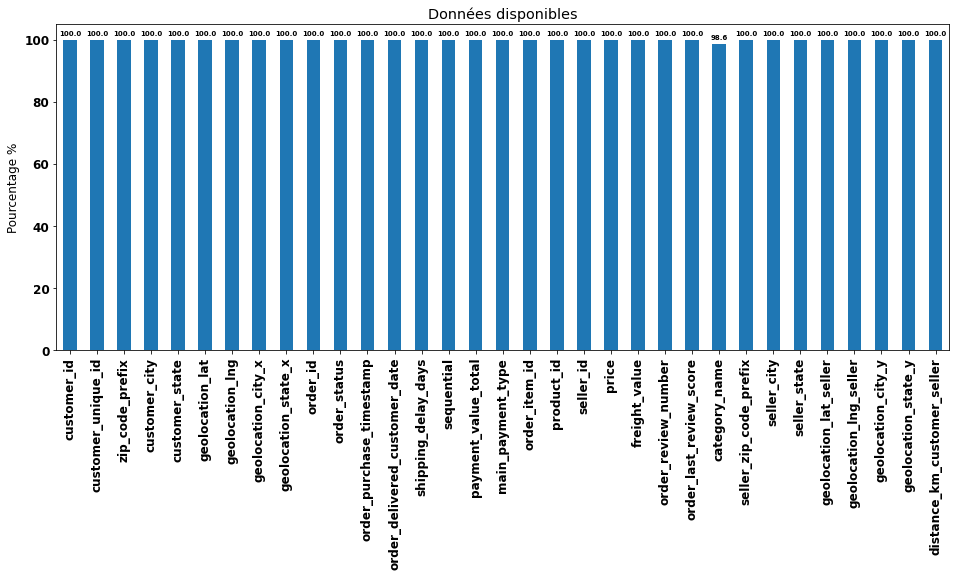

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,geolocation_city_x,geolocation_state_x,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,shipping_delay_days,sequential,payment_value_total,main_payment_type,order_item_id,product_id,seller_id,price,freight_value,order_review_number,order_last_review_score,category_name,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_y,geolocation_state_y,distance_km_customer_seller
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,8.0,1.0,146.87,credit_card,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,1,4,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,347.358827
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,16.0,1.0,335.48,credit_card,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,289.00,46.48,1,5,housewares,88303.0,itajai,SC,-26.912429,-48.677381,itajai,SC,414.407912
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,26.0,1.0,157.73,credit_card,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,1,5,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,29.606634
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-28 16:04:25,14.0,1.0,173.30,credit_card,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,1,5,office_furniture,8577.0,itaquaquecetuba,SP,-23.482623,-46.374490,itaquaquecetuba,SP,19.375066
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-09 20:55:48,11.0,1.0,252.25,credit_card,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,230.00,22.25,1,5,home_confort,14940.0,ibitinga,SP,-21.766477,-48.831547,ibitinga,SP,219.968048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830,são paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-13 20:06:37,6.0,1.0,88.78,credit_card,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,74.90,13.88,1,4,books_general_interest,17400.0,garca,SP,-22.218989,-49.643623,garca,SP,356.367892
113421,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-11 18:54:45,7.0,1.0,129.06,credit_card,1.0,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,114.90,14.16,1,5,sports_leisure,14802.0,araraquara,SP,-21.760806,-48.172285,araraquara,SP,251.678468
113422,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-09 19:03:15,30.0,1.0,56.04,credit_card,1.0,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,37.00,19.04,1,1,health_beauty,3304.0,sao paulo,SP,-23.544897,-46.577772,sao paulo,SP,2368.717679
113423,56b18e2

In [126]:
columnsDataAvailable(df_data_global_olist_final, 0)

--> We may miss some information about category of some product but we decided to keep it for now

In [127]:
df_data_global_olist_final.to_csv('data_global_olist.csv')

--> Some test with our global file

## **Function to agglomerate data by client for time period**

In [84]:
def customer_infos_time(df, time_start, time_stop, name='none'):
    ''' Function to create a dataset of all the data that we wanted for an unique client id for a time period
    the data set raw with all the variable we wanted must be implemented, base is data_global_olist_final
    (important columns with order_purchase_timestamp should be present)
    time start and time end must be input
    the name of the dataframe is optional
    it returns:
    - a new dataframe with a row for each client: R, F, M, main_prod_cat, nb_product by order, top seller, mean_seller_dist_km, 
    mean payment by order, mean_sequential, mean_order_review  columns
    - a new dataframe data_global_olist filtered for the time-period'''
    # filtering the time period
    df_filtered = df.loc[df['order_purchase_timestamp'].between(
        time_start, time_stop)].copy()
    # creating R column and payment_total
    recent_date = df_filtered['order_purchase_timestamp'].max()
    df_filtered['R'] = (
        recent_date - df_filtered['order_purchase_timestamp']).dt.days
    # groupby for each client
    df_data_RFM_filtered = df_filtered.groupby('customer_unique_id').agg(R=('R', min), F=('order_id', pd.Series.nunique),
                                                                         M=('payment_value_total', lambda x: x.unique().sum()), main_prod_cat=('category_name', lambda x: x.value_counts().index[0] if len(x.value_counts()) != 0 else np.nan),
                                                                         nb_prod=('order_item_id', pd.Series.count), nb_prod_by_order=('order_id', lambda x: len(x)/x.nunique()),
                                                                         top_seller=('seller_id', lambda x: x.value_counts(
                                                                         ).index[0] if len(x.value_counts()) != 0 else np.nan),
                                                                         mean_seller_dist_km=('distance_km_customer_seller', lambda x: np.mean(x)))
    # add column mean payment by order
    df_data_RFM_filtered['mean_payment_by_order'] = df_data_RFM_filtered['M'] / \
        df_data_RFM_filtered['F']
    # filtereing df by order to add mean sequential and mean order review by clients
    df_order = df.groupby('order_id').agg(customer_unique_id=('customer_unique_id', pd.Series.unique), sequential=(
        'sequential', pd.Series.unique), review=('order_last_review_score', pd.Series.unique), payment_type=('main_payment_type', pd.Series.unique))
    df_order_customer = df_order.groupby('customer_unique_id').agg(mean_sequential=(
        'sequential', pd.Series.mean), mean_review_score=('review', pd.Series.mean),
        main_payment_type=('payment_type', lambda x: x.value_counts().index[0] if len(x.value_counts()) != 0 else np.nan))
    # merge last data
    df_data_RFM_filtered = pd.merge(
        df_data_RFM_filtered, df_order_customer, left_index=True, right_on='customer_unique_id', how='left')
    df_data_RFM_filtered.name = name
    return df_data_RFM_filtered, df_filtered

## **let's try to evaluate linear correlation with our variables(especially with our created variables)**

In [128]:
df_data_global_olist_final.describe()

,zip_code_prefix,geolocation_lat,geolocation_lng,shipping_delay_days,sequential,payment_value_total,order_item_id,price,freight_value,order_review_number,order_last_review_score,seller_zip_code_prefix,geolocation_lat_seller,geolocation_lng_seller,distance_km_customer_seller
count,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000,107936.000000
mean,34964.783872,-21.269721,-46.217247,11.962237,1.044795,156.186030,1.181821,106.618565,19.402387,1.005929,4.074424,24390.327703,-22.808336,-47.254778,593.275338
std,29868.026738,5.544061,4.032223,9.423555,0.379251,144.654204,0.623268,112.965951,13.757948,0.077495,1.352474,27580.122929,2.677389,2.314950,587.870332
min,1003.000000,-36.605374,-72.666706,0.000000,1.000000,9.590000,1.000000,0.850000,0.000000,1.000000,1.000000,1001.000000,-36.605374,-64.283946,0.000000
25%,11070.000000,-23.591378,-48.111971,6.000000,1.000000,65.000000,1.000000,39.900000,12.990000,1.000000,4.000000,6429.000000,-23.611654,-48.831547,182.011610
50%,24230.000000,-22.931508,-46.634639,10.000000,1.000000,112.535000,1.000000,72.000000,16.170000,1.000000,5.000000,13568.000000,-23.422076,-46.755211,430.269050
75%,58280.000000,-20.234325,-43.683088,15.000000,1.000000,189.252500,1.000000,129.900000,20.860000,1.000000,5.000000,26562.000000,-21.766477,-46.518082,786.052269
max,99980.000000,42.184003,-8.577855,209.000000,26.000000,999.680000,21.000000,969.000000,269.000000,3.000000,5.000000,99730.000000,-2.546079,-34.847856,8746.547152


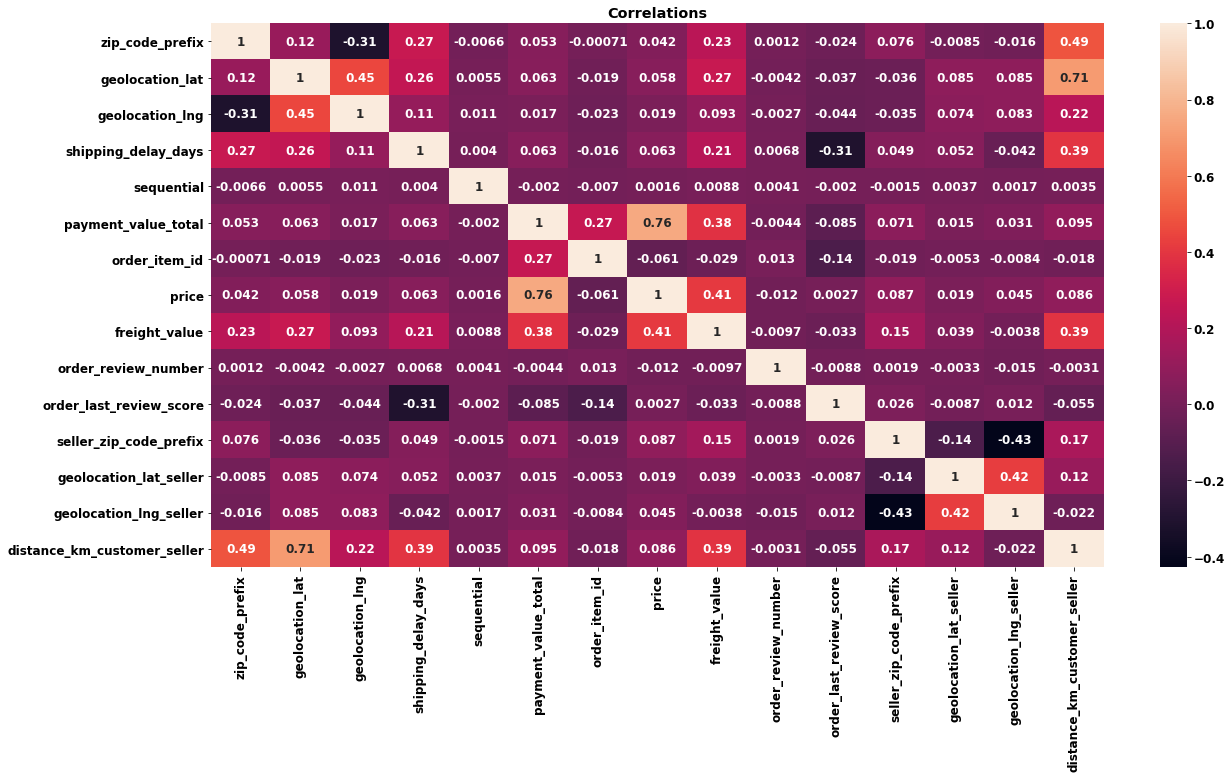

In [110]:
figure_corr = plt.figure(figsize=(20, 10))
plt.title(f'Correlations', fontweight='bold')
sns.heatmap(df_data_global_olist_final.corr(), annot=True)
plt.savefig('Analyse des corrélations.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> p-values analysis for pearson correlation

In [114]:
# H0 'variables and target are independent'
# H1 'variables and target are dependent'

list_numerical_features = [
    'shipping_delay_days', 'distance_km_customer_seller']

# target1: 'order_last_review_score'
df_statistical_target1 = pd.DataFrame(
    [], index=['Coefficient de corrélation linéaire', 'p_value'])
for v in list_numerical_features:
    df_test_statistical = df_data_global_olist_final.loc[(df_data_global_olist_final['order_last_review_score'].notnull()) & (df_data_global_olist_final[v].notnull())]
    stat, p_value=pearsonr(
        df_test_statistical[v], df_test_statistical['order_last_review_score'])
    df_statistical_target1[v]=[stat, p_value]

df_statistical_target1

,shipping_delay_days,distance_km_customer_seller
Coefficient de corrélation linéaire,-0.305655,-5.511385e-02
p_value,0.000000,1.603191e-74


In [116]:
# target2: 'freight_value'
df_statistical_target2 = pd.DataFrame(
    [], index=['Coefficient de corrélation linéaire', 'p_value'])
for v in list_numerical_features:
    df_test_statistical = df_data_global_olist_final.loc[(df_data_global_olist_final['freight_value'].notnull()) & (df_data_global_olist_final[v].notnull())]
    stat, p_value=pearsonr(
        df_test_statistical[v], df_test_statistical['freight_value'])
    df_statistical_target2[v]=[stat, p_value]

df_statistical_target2

,shipping_delay_days,distance_km_customer_seller
Coefficient de corrélation linéaire,0.214671,0.391073
p_value,0.000000,0.000000


In [117]:
# Corrélation between distance and shipping delay
df_statistical_target3 = pd.DataFrame(
    [], index=['Coefficient de corrélation linéaire', 'p_value'])
for v in list_numerical_features:
    df_test_statistical = df_data_global_olist_final.loc[(df_data_global_olist_final['shipping_delay_days'].notnull()) & (df_data_global_olist_final[v].notnull())]
    stat, p_value=pearsonr(
        df_test_statistical[v], df_test_statistical['shipping_delay_days'])
    df_statistical_target3[v]=[stat, p_value]

df_statistical_target3

,shipping_delay_days,distance_km_customer_seller
Coefficient de corrélation linéaire,1.0,0.393237
p_value,0.0,0.000000


--> For all tests p-value is < 1%. it is unlikely that our variables are independent of our target! Hypotesis H0 can be rejected with a confidence of 99%.<br/>
--> Our shipping delay is interesseting to link to our review score for later, let's try to visualize that

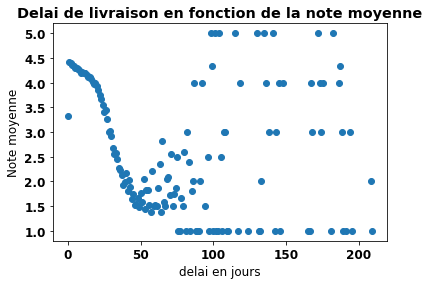

In [179]:
df_delay_review = df_data_global_olist_final.groupby('shipping_delay_days').agg(
    mean_review_score=('order_last_review_score', pd.Series.mean))

plt.scatter(df_delay_review.index, df_delay_review['mean_review_score'])
plt.title('Delai de livraison en fonction de la note moyenne', fontweight='bold')
plt.xlabel('delai en jours')
plt.ylabel('Note moyenne')
plt.savefig('Delai_de_livraison_fct_note_moyenne.jpg.', dpi=300, bbox_inches='tight')
plt.show()

In [196]:
before_70_days = df_data_global_olist_final.loc[df_data_global_olist_final['shipping_delay_days'] < 70]['shipping_delay_days'].count()
after_70_days = df_data_global_olist_final.loc[df_data_global_olist_final['shipping_delay_days'] >= 70]['shipping_delay_days'].count()

--> It seems that before 70 days of delay shipping our correlation seemed confirmed but after it is complicated to conclude <br/>
--> let's evaluate the proprotion of points used (before and after 70 days of shipping delay)

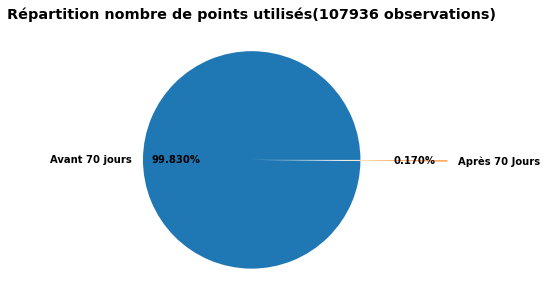

In [197]:
figure_delay_review = plt.figure(figsize=(5, 5), facecolor='w')
x = [before_70_days, after_70_days]
plt.title(
    f'Répartition nombre de points utilisés({np.sum(x)} observations)', fontweight='bold')
plt.axis('off')
expl = [0 if i/np.sum(x) > 0.02 else 0.8 for i in x]
plt.pie(x, labels=['Avant 70 jours', 'Après 70 Jours'], autopct="%.3f%%", pctdistance=0.7,
        explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.savefig('Répartitions volumes_de_points_delai_note.png',
            dpi=300, bbox_inches='tight')
plt.show()

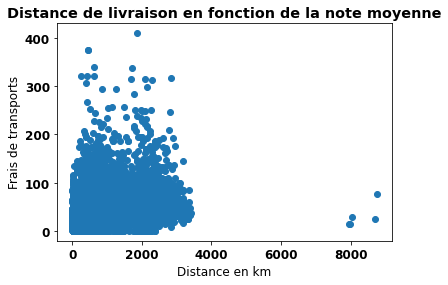

In [121]:
df_distance_review = df_data_global_olist_final.groupby('distance_km_customer_seller').agg(
    mean_review_score=('freight_value', pd.Series.mean))

plt.scatter(df_distance_review.index, df_distance_review['mean_review_score'])
plt.title('Distance de livraison en fonction de la note moyenne', fontweight='bold')
plt.xlabel('Distance en km')
plt.ylabel('Frais de transports')
plt.show()

--> Shipping delai seems a little linked with the review score (the more the less note) <br/>
--> Distance seems logicaly linked to the freight value (but less interessting for us)

In [129]:
df_data_global_olist_final['order_purchase_timestamp'] = pd.to_datetime(
    df_data_global_olist_final['order_purchase_timestamp'])
df_customer_all, _ = customer_infos_time(
    df_data_global_olist_final, '2016-01-01', '2018-12-31', 'df_customer_all')

In [131]:
df_customer_all.head()

,R,F,M,main_prod_cat,nb_prod,nb_prod_by_order,top_seller,mean_seller_dist_km,mean_payment_by_order,mean_sequential,mean_review_score,main_payment_type
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,bed_bath_table,1.0,1.0,da8622b14eb17ae2831f4ac5b9dab84a,109.307581,141.90,1.0,5.0,credit_card
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,health_beauty,1.0,1.0,138dbe45fc62f1e244378131a6801526,22.853354,27.19,1.0,4.0,credit_card
0000f46a3911fa3c0805444483337064,536,1,86.22,stationery,1.0,1.0,3d871de0142ce09b7081e2b9d1733cb1,517.883143,86.22,1.0,3.0,credit_card
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,telephony,1.0,1.0,ef506c96320abeedfb894c34db06f478,2484.002335,43.62,1.0,4.0,credit_card
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,telephony,1.0,1.0,70a12e78e608ac31179aea7f8422044b,154.073565,196.89,1.0,5.0,credit_card
